In [157]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
import tqdm as tqdm
import tensorflow_hub as hub
import tensorflow as tf
from bert_tokenization import bertTokenization as tokenization
import tensorflow.keras.backend as K
import gc
import os
from scipy.stats import spearmanr
from math import floor, ceil
import seaborn as sns

np.set_printoptions(suppress=True)

**lable selected for our project:** 
answer_relevance prediction

In [158]:
PATH = 'input/Data/'
BERT_PATH = 'input/bert-base-from-tfhub/bert_en_uncased_L-12_H-768_A-12'
tokenizer = tokenization.FullTokenizer(BERT_PATH+'/assets/vocab.txt', True)
MAX_SEQUENCE_LENGTH = 512

df_train = pd.read_csv(PATH+'train.csv')
df_test = pd.read_csv(PATH+'test.csv')
df_sub = pd.read_csv(PATH+'sample_submission.csv')

##remove later!!!
df_train = df_train[:10]
df_test = df_test[:10]
df_sub = df_sub[:10]

print('train shape =', df_train.shape)
print('test shape =', df_test.shape)

train shape = (10, 41)
test shape = (10, 11)


**DATA engineering:**


1.NaN handling

In [159]:
count = 0
for var in df_train.head(1):
    for elem in df_train[var]:
        if elem == 'NaN' :
            count +=1    
    print(var , count/df_train.shape[0])
    count = 0


qa_id 0.0
question_title 0.0
question_body 0.0
question_user_name 0.0
question_user_page 0.0
answer 0.0
answer_user_name 0.0
answer_user_page 0.0
url 0.0
category 0.0
host 0.0
question_asker_intent_understanding 0.0
question_body_critical 0.0
question_conversational 0.0
question_expect_short_answer 0.0
question_fact_seeking 0.0
question_has_commonly_accepted_answer 0.0
question_interestingness_others 0.0
question_interestingness_self 0.0
question_multi_intent 0.0
question_not_really_a_question 0.0
question_opinion_seeking 0.0
question_type_choice 0.0
question_type_compare 0.0
question_type_consequence 0.0
question_type_definition 0.0
question_type_entity 0.0
question_type_instructions 0.0
question_type_procedure 0.0
question_type_reason_explanation 0.0
question_type_spelling 0.0
question_well_written 0.0
answer_helpful 0.0
answer_level_of_information 0.0
answer_plausible 0.0
answer_relevance 0.0
answer_satisfaction 0.0
answer_type_instructions 0.0
answer_type_procedure 0.0
answer_type_

2.Extraction of 'host' and 'category' to 'sub_category'

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


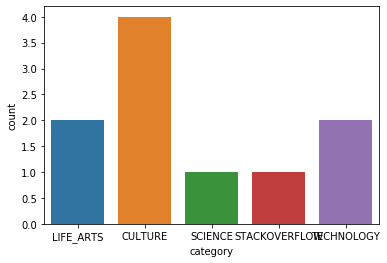

In [160]:
%matplotlib inline
sns.countplot(x='category', data=df_train)

In [161]:
df_train['host']=df_train['host'].apply(lambda x:(x.replace(x ,x.split('.')[0])))
df_test['host']=df_test['host'].apply(lambda x:(x.replace(x ,x.split('.')[0])))

In [162]:
df_train.columns = df_train.columns.str.replace('host', 'sub_category')
df_test.columns = df_test.columns.str.replace('host', 'sub_category')

In [163]:
#we trying to figure out if category is redundent due to the sub category
arr_sub_category = {}
for sub in df_train['sub_category'].unique():
    data = df_train[df_train['sub_category'] == sub]
    arr = df_train[df_train['sub_category'] == sub]['category'].unique()
    if len(arr) > 1:
        arr_sub_category[sub] = arr
        print(sub, arr)
        #correlation between two features

In [164]:
# split each sub_category found to be multiplied to more than one category 
#(in order to drop the category feature without loosing any important info)
for key in arr_sub_category.keys():
    for val in arr_sub_category[key]:
        df_train[(df_train['sub_category'] == key) & (df_train['category'] == val)] = df_train[(df_train['sub_category'] == key) & (df_train['category'] == val)].apply(lambda x :x.replace(key, key+'_'+val))


In [165]:
# checking
print(df_train['sub_category'].unique())

['photo' 'rpg' 'electronics' 'judaism' 'graphicdesign' 'stackoverflow'
 'askubuntu' 'gaming' 'serverfault']


3.features plots

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


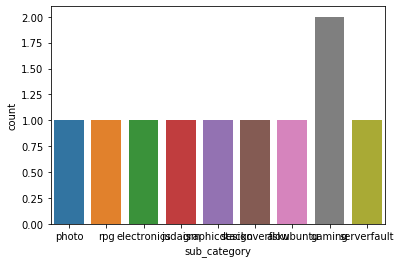

In [166]:
%matplotlib inline
sns.countplot(x='sub_category', data=df_train)

4.correlation sorted list between features

In [167]:
 def corrank(X):## to think about relevant correlations (sub_c and lable?, is text coor is relevant?)
        import itertools
        dff = pd.DataFrame([[(i,j),X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(method = 'spearman'), 2))],columns=['pairs','corr'])    
        print(dff.sort_values(by='corr',ascending=False))

In [168]:
corrank(df_train)

                                                 pairs      corr
313  (question_type_compare, question_type_definition)  1.000000
140  (question_fact_seeking, question_has_commonly_...  1.000000
396   (question_type_procedure, answer_type_procedure)  0.990665
189  (question_interestingness_others, question_int...  0.917211
450            (answer_relevance, answer_satisfaction)  0.855414
224  (question_interestingness_self, question_well_...  0.824089
437    (answer_level_of_information, answer_plausible)  0.809831
445            (answer_plausible, answer_satisfaction)  0.785667
440  (answer_level_of_information, answer_type_inst...  0.773021
444               (answer_plausible, answer_relevance)  0.761454
49   (question_asker_intent_understanding, question...  0.715678
430                 (answer_helpful, answer_plausible)  0.704970
439  (answer_level_of_information, answer_satisfact...  0.702446
202  (question_interestingness_others, question_wel...  0.671729
95     (question_conversa

**5.tokenization?**

6.**Categorizing questions**
#HowTo - instructions (looking for actions in the answer)
#Why 
#What / which kind of - classification
#what is better - comparison
#when / how often - time
#what/ how many/ how much - quantative
#where - places
#who / whom - person
#how does / how are - comprehension
#can/ could - capability
#should /would you/ do you want / is, are, am / does- Yes/No questions, willing
#aren't you? wasn't it? - tag questions (in YES/NO)

In [169]:
# data_a = np.array([['Can an affidavit be used in Beit Din?', 10], ['How can I write HTML and send as an email?', 15], ['How do I remove a Facebook app request?', 14], ['How do you grapple in Dead Rising 3?', 1], ['How do you make a binary image in Photoshop?', 1]]) 
# df_a = pd.DataFrame(data_a)
# df_a.columns = ["question", "num"]
# print(df_a)

# from adam_qas import adam_script as adam
# dfOut = pd.DataFrame(np.array([["","",""]]))
# dfOut.columns = ["q_class","q_keywords","quary"]
# dfOut = dfOut[:-1]
# new_features = adam.activate(df_a['question'], dfOut)
# print(new_features.head(2))
# df_a.join(new_features)
# print(df_a.head(5))

#### Calling adam's algorithem to produce new features 

In [170]:
# from adam_qas import adam_script as adam
# dfOut = pd.DataFrame(np.array([["","",""]]))
# dfOut.columns = ["q_class","q_keywords","quary"]
# dfOut = dfOut[:-1]

# new_features = adam.activate(df_train['question_title'], dfOut)
# print(new_features)

# df_new_train=pd.concat([df_train,new_features], axis=1, sort=False)
# df_new_test=pd.concat([df_test,new_features], axis=1, sort=False)

In [171]:
# df_new_train.to_csv(PATH+'df_new_train.csv', index=False)
# df_new_test.to_csv(PATH+'df_new_test.csv', index=False)

?.Redefine the features passed to the input categories - add sub_categoty

In [172]:
# df_new_train.head(10)

In [173]:
# df_new_test.head(10)

In [174]:
df_test = pd.read_csv(PATH+'df_new_test.csv')
df_train = pd.read_csv(PATH+'df_new_train.csv')
output_categories = list(df_train.columns[11:41])
# input_categories = list(df_train.columns[[1,2,5]])#orogional code
input_categories = list(df_train.columns[[1,2,5,10,41,42,43]]) # we added the sub_categoty!
print('\noutput categories:\n\t', output_categories)
print('\ninput categories:\n\t', input_categories)


output categories:
	 ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']

input categories:
	 ['question_title', 'question_body', 'answer', 'sub_category', 'q_class', 'q_keywords', 'quary']


In [175]:
def _get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def _get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    first_sep = True
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            if first_sep:
                first_sep = False 
            else:
                current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

def _get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

def _trim_input(title, question, answer, sub_category, q_class, q_keywords, quary, max_sequence_length, 
                t_max_len=30, q_max_len=111, a_max_len=111, s_c_max_len=30, q_c_max_len=10, q_k_max_len=106, qu_max_len=106):

    t   = tokenizer.tokenize(title)
    q   = tokenizer.tokenize(question)
    a   = tokenizer.tokenize(answer)
    s_c = tokenizer.tokenize(sub_category)
    q_c = tokenizer.tokenize(q_class)
    q_k = tokenizer.tokenize(q_keywords)
    qu  = tokenizer.tokenize(quary)
    
    t_len   = len(t)
    q_len   = len(q)
    a_len   = len(a)
    s_c_len = len(s_c)
    q_c_len = len(q_c)
    q_k_len = len(q_k)
    qu_len  = len(qu)

    if (t_len+q_len+a_len+4) > (max_sequence_length/2):
        if t_max_len > t_len:
            t_new_len = t_len
            a_max_len = a_max_len + floor((t_max_len - t_len)/2)
            q_max_len = q_max_len + ceil((t_max_len - t_len)/2)
        else:
            t_new_len = t_max_len
      
        if a_max_len > a_len:
            a_new_len = a_len 
            q_new_len = q_max_len + (a_max_len - a_len)
        elif q_max_len > q_len:
            a_new_len = a_max_len + (q_max_len - q_len)
            q_new_len = q_len
        else:
            a_new_len = a_max_len
            q_new_len = q_max_len
        
        if t_new_len+a_new_len+q_new_len+4 != max_sequence_length/2:
            raise ValueError("New sequence length should be %d, but is %d" 
                             % (max_sequence_length/2, (t_new_len+a_new_len+q_new_len+4)))
        t   = t[:t_new_len]
        q   = q[:q_new_len]
        a   = a[:a_new_len]
    
    if (s_c_len+q_c_len+q_k_len+qu_len+4) > (max_sequence_length/2):
        if s_c_max_len > s_c_len:
            s_c_new_len = s_c_len
            q_k_max_len = q_k_max_len + floor((s_c_max_len - s_c_len)/2)
            qu_max_len = qu_max_len + ceil((s_c_max_len - s_c_len)/2)
        else:
            s_c_new_len = s_c_max_len
        
        if q_c_max_len > q_c_len:
            q_c_new_len = q_c_len
            q_k_max_len = q_k_max_len + floor((q_c_max_len - q_c_len)/2)
            qu_max_len = qu_max_len + ceil((q_c_max_len - q_c_len)/2)
        else:
            q_c_new_len = q_c_max_len
      
        if q_k_max_len > q_k_len:
            q_k_new_len = q_k_len 
            qu_new_len = qu_max_len + (q_k_max_len - q_k_len)
        elif qu_max_len > qu_len:
            q_k_new_len = q_k_max_len + (qu_max_len - qu_len)
            qu_new_len = qu_len
        else:
            q_k_new_len = q_k_max_len
            qu_new_len = qu_max_len
            
        if s_c_new_len+q_c_new_len+q_k_new_len+qu_new_len+4 != max_sequence_length:
            raise ValueError("New sequence length should be %d, but is %d" 
                             % (max_sequence_length/2, (s_c_new_len+q_c_new_len+q_k_new_len+qu_new_len+4)))
        s_c = s_c[:s_c_new_len]
        q_c = q_c[:q_c_new_len]
        q_k = q_k[:q_k_new_len]
        qu  = qu[:qu_new_len]
    
    return t, q, a, s_c, q_c, q_k, qu

def _convert_to_bert_inputs(title, question, answer, sub_category, q_class, q_keywords, quary, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for BERT"""
    
    stoken = ["[CLS]"] + title + ["[SEP]"] + question + ["[SEP]"] + answer + ["[SEP]"] + sub_category + ["[SEP]"] + q_class + ["[SEP]"] + q_keywords + ["[SEP]"] + quary + ["[SEP]"]

    input_ids = _get_ids(stoken, tokenizer, max_sequence_length)
    input_masks = _get_masks(stoken, max_sequence_length)
    input_segments = _get_segments(stoken, max_sequence_length)

    return [input_ids, input_masks, input_segments]

def compute_input_arays(df, columns, tokenizer, max_sequence_length):
    input_ids, input_masks, input_segments = [], [], []

    for index, instance in df[columns].iterrows():
        t, q, a, s_c, q_c, q_k, qu = instance.question_title, instance.question_body, instance.answer, instance.sub_category, instance.q_class, instance.q_keywords, instance.quary

        t, q, a, s_c, q_c, q_k, qu = _trim_input(t, q, a, s_c, q_c, q_k, qu, max_sequence_length)
       
       
        ids, masks, segments = _convert_to_bert_inputs(t, q, a, s_c, q_c, q_k, qu, tokenizer, max_sequence_length)
        
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
        
    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]


def compute_output_arrays(df, columns):
    return np.asarray(df[columns])


In [176]:
def compute_spearmanr(trues, preds):
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        rhos.append(
            spearmanr(col_trues, col_pred + np.random.normal(0, 1e-7, col_pred.shape[0])).correlation)
    return np.mean(rhos)


class CustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, valid_data, test_data, batch_size=16, fold=None):

        self.valid_inputs = valid_data[0]
        self.valid_outputs = valid_data[1]
        self.test_inputs = test_data
        
        self.batch_size = batch_size
        self.fold = fold
        
    def on_train_begin(self, logs={}):
        self.valid_predictions = []
        self.test_predictions = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.valid_predictions.append(
            self.model.predict(self.valid_inputs, batch_size=self.batch_size))
        
        rho_val = compute_spearmanr(
            self.valid_outputs, np.average(self.valid_predictions, axis=0))
        
        print("\nvalidation rho: %.4f" % rho_val)
        
        if self.fold is not None:
            self.model.save_weights(f'bert-base-{fold}-{epoch}.h5py')
        
        self.test_predictions.append(
            self.model.predict(self.test_inputs, batch_size=self.batch_size)
        )

def bert_model():
    
    input_word_ids = tf.keras.layers.Input(
        (MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids')
    input_masks = tf.keras.layers.Input(
        (MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks')
    input_segments = tf.keras.layers.Input(
        (MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_segments')
    
    bert_layer = hub.KerasLayer(BERT_PATH, trainable=True)
    
    _, sequence_output = bert_layer([input_word_ids, input_masks, input_segments])
    
    x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(30, activation="sigmoid", name="dense_output")(x)

    model = tf.keras.models.Model(
        inputs=[input_word_ids, input_masks, input_segments], outputs=out)
    
    return model    
        
def train_and_predict(model, train_data, valid_data, test_data, 
                      learning_rate, epochs, batch_size, loss_function, fold):
        
    custom_callback = CustomCallback(
        valid_data=(valid_data[0], valid_data[1]), 
        test_data=test_data,
        batch_size=batch_size,
        fold=None)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss_function, optimizer=optimizer)
    model.fit(train_data[0], train_data[1], epochs=epochs, 
              batch_size=batch_size, callbacks=[custom_callback])
    
    return custom_callback


In [177]:
gkf = GroupKFold(n_splits=10).split(X=df_train.question_body, groups=df_train.question_body) ############## originaln_splits=10

outputs = compute_output_arrays(df_train, output_categories)
inputs = compute_input_arays(df_train, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)
test_inputs = compute_input_arays(df_test, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)

In [178]:
histories = []
for fold, (train_idx, valid_idx) in enumerate(gkf):
    
    # will actually only do 3 folds (out of 5) to manage < 2h
    if fold < 3:
        K.clear_session()
        model = bert_model()

        train_inputs = [inputs[i][train_idx] for i in range(3)]
        train_outputs = outputs[train_idx]

        valid_inputs = [inputs[i][valid_idx] for i in range(3)]
        valid_outputs = outputs[valid_idx]

        # history contains two lists of valid and test preds respectively:
        #  [valid_predictions_{fold}, test_predictions_{fold}]
        history = train_and_predict(model, 
                          train_data=(train_inputs, train_outputs), 
                          valid_data=(valid_inputs, valid_outputs),
                          test_data=test_inputs, 
                          learning_rate=3e-5, epochs=5, batch_size=8,
                          loss_function='binary_crossentropy', fold=fold)

        histories.append(history)

Train on 9 samples
Epoch 1/5


KeyboardInterrupt: 

In [123]:
# test_predictions = [histories[i].test_predictions for i in range(len(histories))]
# test_predictions = [np.average(test_predictions[i], axis=0) for i in range(len(test_predictions))]
# test_predictions = np.mean(test_predictions, axis=0)

# df_sub =df_sub.assign(results = test_predictions)
# print(df_sub)
# df_sub.to_csv('submission.csv', index=False)

notes:

